<a href="https://www.kaggle.com/code/eduardomontilva/cnn-sign-language-mnist-95-30-acc?scriptVersionId=90887237" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
The Sign Language Dataset (MNIST) is a dataset that contains images of sign languages together with a label. In this project we want to create a Machine Learning model that is capable of recognizing sign language images and being able to classify them correctly.

It should be noted that each image represents a letter of the alphabet, so recognizing it correctly can be used to predict and/or translate the sign language to text.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2

# Load train and test dataset

In [2]:
train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## Take each image in train and test and save it to folders

In [3]:
if not os.path.exists('../train'):
    os.mkdir('../train')
if not os.path.exists('../test'):
    os.mkdir('../test')

for i, row in enumerate(train.to_numpy()):
    label = row[0]
    data = row[1:]
    data = data.reshape((28,28))
    if not os.path.exists(f'../train/{label}'):
        os.mkdir(f'../train/{label}')
    cv2.imwrite(f'../train/{label}/{i}.jpeg', data)
    
for i, row in enumerate(test.to_numpy()):
    label = row[0]
    data = row[1:]
    data = data.reshape((28,28))
    if not os.path.exists(f'../test/{label}'):
        os.mkdir(f'../test/{label}')
    cv2.imwrite(f'../test/{label}/{i}.jpeg', data)

# We see that we have 780 = 28^2 pixels per image, so we reshape all the images into arrays of size 28x28x1

# We also normalize each pixel between 0 and 1

In [4]:
y_train = train['label'].values
X_train = train.drop(columns = ['label']).to_numpy().reshape((train.shape[0], 28, 28,1)).astype('float64')/255.0

y_test = test['label'].values
X_test = test.drop(columns = ['label']).to_numpy().reshape((test.shape[0], 28,28,1)).astype('float64')/255.0

print(X_train.shape)

(27455, 28, 28, 1)


# Convert 'y' to categorical

In [5]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Count the number of labels

In [6]:
n_labels = y_train.shape[1]-1
print(f"There are {n_labels} labels in the dataset")

There are 24 labels in the dataset


# Plot some images from training 

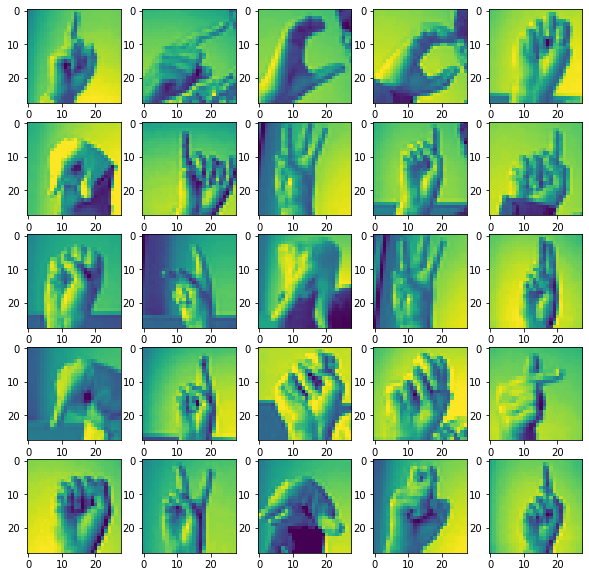

In [7]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (10,10))
i = 0
j = 0
for n in range(25):
    axes[i, j].imshow(X_train[n])
    j += 1
    if j%5 == 0:
        i += 1
        j = 0
        
plt.show()

## Generators

In [8]:
datagen = ImageDataGenerator(
    rescale = 1/255.0,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest',
    validation_split=0.25)

In [9]:
train_generator = datagen.flow_from_directory(
    '../train',
    class_mode = 'categorical',
    batch_size = 20,
    target_size = (28,28))

Found 27455 images belonging to 24 classes.


In [10]:
test_generator = datagen.flow_from_directory(
    '../test',
    class_mode = 'categorical',
    batch_size = 20,
    target_size = (28,28))

Found 7172 images belonging to 24 classes.


# Let's create a model

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = (28,28,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(n_labels, activation = 'softmax')
])
model.summary()

2022-03-22 02:17:55.567676: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          2

# Fit Model

In [12]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#history = model.fit(X_train, y_train, epochs = 15, validation_data = (X_test, y_test))
history = model.fit(train_generator, epochs = 15, validation_data = test_generator)

2022-03-22 02:17:56.281281: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
1373/1373 [==============================] - 69s 50ms/step - loss: 2.2086 - accuracy: 0.3069 - val_loss: 3.4979 - val_accuracy: 0.2146
Epoch 2/15
1373/1373 [==============================] - 64s 46ms/step - loss: 1.2564 - accuracy: 0.5775 - val_loss: 1.3514 - val_accuracy: 0.5671
Epoch 3/15
1373/1373 [==============================] - 61s 45ms/step - loss: 0.8727 - accuracy: 0.6997 - val_loss: 0.8191 - val_accuracy: 0.7207
Epoch 4/15
1373/1373 [==============================] - 60s 44ms/step - loss: 0.7163 - accuracy: 0.7564 - val_loss: 0.7562 - val_accuracy: 0.7394
Epoch 5/15
1373/1373 [==============================] - 63s 46ms/step - loss: 0.6108 - accuracy: 0.7909 - val_loss: 0.6385 - val_accuracy: 0.7796
Epoch 6/15
1373/1373 [==============================] - 63s 46ms/step - loss: 0.5338 - accuracy: 0.8152 - val_loss: 0.9829 - val_accuracy: 0.6801
Epoch 7/15
1373/1373 [==============================] - 62s 45ms/step - loss: 0.4684 - accuracy: 0.8378 - val_loss: 0.5706 -

# Plot accuracy and loss

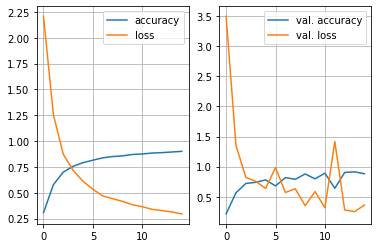

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].plot(history.history['accuracy'], label = 'accuracy')
axes[0].plot(history.history['loss'], label = 'loss')
axes[1].plot(history.history['val_accuracy'], label = 'val. accuracy')
axes[1].plot(history.history['val_loss'], label = 'val. loss')


axes[0].legend()
axes[0].grid(True)
axes[1].legend()
axes[1].grid(True)
plt.show()

# Evaluate

In [14]:
loss, acc, = model.evaluate(test_generator)

359/359 [==============================] - 9s 26ms/step - loss: 0.3676 - accuracy: 0.8735


# Note for future

I plan to increase the accuracy by adding Image Augmentation, selecting the optimal Learning Rate, etc